## Import Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk, string, re, time
from datetime import datetime as dt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/june/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/june/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
dataset_OG = pd.read_csv('emails.csv')
data = dataset_OG.copy() ## manipulate this df
data.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [3]:
# EXTRACTING INFORMATION
origin, fr, to, date, sub, messages = [], [], [], [], [], []
cc, bcc = [], []

e = data.message.shape[0]

start_time = time.time()
# For each message
for i in range(e):
    a, lst = data.message[i].split('\n'), []
    if i % 60000 == 0:
        print('Pre-processing on the way...: {:05.2f}%'.format(i/e*100))
    
    origin.append(next(item for item in a if 'X-Origin:' in item))
    fr.append(next(item for item in a if 'X-From:' in item))
    to.append(next(item for item in a if 'X-To:' in item))
    sub.append(next(item for item in a if 'Subject: ' in item))
    date.append(next(item for item in a if 'Date:' in item))
    cc.append(next(item for item in a if 'X-cc:' in item))
    bcc.append(next(item for item in a if 'X-bcc:' in item))
    lst.append(next(a[i+1:] for i in range(len(a)) if 'X-FileName:' in a[i]))
    messages.append([''.join(sub_list) for sub_list in lst][0])
    
    if i == e - 1:
        print('Data Extracting Complete!')
        print("--- %s seconds ---" % (time.time() - start_time))        


Pre-processing on the way...: 00.00%
Pre-processing on the way...: 11.60%
Pre-processing on the way...: 23.19%
Pre-processing on the way...: 34.79%
Pre-processing on the way...: 46.39%
Pre-processing on the way...: 57.98%
Pre-processing on the way...: 69.58%
Pre-processing on the way...: 81.17%
Pre-processing on the way...: 92.77%
Data Extracting Complete!
--- 20.239891290664673 seconds ---


In [4]:
# Cleaning
for i in range(len(origin)):
    if i % 60000 == 0:
        print('Pre-processing...: {:05.2f}%'.format(i/e*100))
    
    origin[i] = re.findall(r'(?<=X-Origin: ).*$', origin[i])[0]
    fr[i] = re.findall(r'(?<=X-From: ).*$', fr[i])[0]
    to[i] = re.findall(r'(?<=X-To: ).*$', to[i])[0]
    date[i] = re.findall(r'(?<=Date: ).*$', date[i])[0]
    sub[i] = re.findall(r'(?<=Subject: ).*$', sub[i])[0]
    cc[i] = re.findall(r'(?<=X-cc: ).*$', cc[i])[0]
    bcc[i] = re.findall(r'(?<=X-bcc: ).*$', bcc[i])[0]
    
    if i == e - 1:
        print('Data Cleaning Complete!')

Pre-processing...: 00.00%
Pre-processing...: 11.60%
Pre-processing...: 23.19%
Pre-processing...: 34.79%
Pre-processing...: 46.39%
Pre-processing...: 57.98%
Pre-processing...: 69.58%
Pre-processing...: 81.17%
Pre-processing...: 92.77%
Data Cleaning Complete!


In [5]:
stop = stopwords.words('english')
stopwords_dict = Counter(stop)

def middle(input):
    inp = re.split(r'/', input)
    inp.pop(0)
    inp.pop()
    return '/'.join(inp)

#    Remove punctuation
def remove_punctuation(s):
    return ''.join([s[i] for i in np.arange(len(s)) if not s[i] in string.punctuation]).lower()

def remove_unnecessary_words(s):
    add_stop = ['items', 'item', 'mails', 'mail', 'email', 'emails', 'message', 'messages',
                  'inboxes', 'inbox', 'threads', 'thread', 'untitled', 'all ', 'general']
    stopwords_dict1 = Counter(add_stop)
    return ' '.join([word for word in s.split(' ') if stopwords_dict1[word] == 0]).lower()

def remove_stops(input):
    return ' '.join([word for word in input.split(' ') if stopwords_dict[word]==0])

def remove_number(input):
    pun, output = "0123456789", ""
    for c in input:
        if c not in pun:
            output += c
    return output.lower()

def filtering(input):
    input = input.replace('_', ' ').replace('/', ' ')
    return input.strip().lower()
  
def date_convert(input):
    u = input - pd.Timestamp("1970-01-01")
    return u // pd.Timedelta('1s')

def helper(input):
    return input + ' ' if input == 're' else input

def length_helper(input):
    return len(input.split(' '))

In [6]:
fold = data.file.apply(middle)
date1 =  pd.Series(date)
day = date1.apply(lambda x: x[:3]).apply(str.lower) # weekdays
date = date1.apply(lambda x: x[5:-12])
cc = pd.Series(cc).apply(lambda x: 0 if x == '' else 1)
bcc = pd.Series(bcc).apply(lambda x: 0 if x == '' else 1)

In [7]:
data = pd.DataFrame()
data['employee'] = origin
data['from'] = fr
data['to'] = to
data['date'] = date
data['day'] = day
data['subject'] = sub
data['message'] = messages
data['cc'] = cc
data['bcc'] = bcc
data['folder'] = fold

In [8]:
# Dropping rows with empty/blank element
data.drop(data.query(
    "subject == '' | folder == ''"
).index, inplace=True)

In [9]:
data['date'] = pd.to_datetime(data['date'])
data['folder'] = data['folder'].apply(filtering).apply(remove_unnecessary_words)
data['message'] = data['message'].apply(remove_punctuation).apply(remove_stops)
data['subject'] = data['subject'].apply(remove_punctuation)
data['day'] = data['day'].apply(remove_punctuation)
data['time'] = data.date.apply(date_convert)
data['reply'] = data.subject.apply(helper).apply(lambda x: 1 if 're ' in x else 0)
data['message_length'] = data.message.apply(length_helper)
data['subject_length'] = data.subject.apply(length_helper)

In [10]:
data.head()

,employee,from,to,date,day,subject,message,cc,bcc,folder,time,reply,message_length,subject_length
1,Allen-P,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,2001-05-04 13:51:00,fri,re,traveling business meeting takes fun trip esp...,0,0,sent,988984260,1,84,1
2,Allen-P,Phillip K Allen,Leah Van Arsdall,2000-10-18 03:00:00,wed,re test,test successful way go,0,0,sent,971838000,1,5,2
4,Allen-P,Phillip K Allen,Greg Piper,2000-08-31 05:07:00,thu,re hello,lets shoot tuesday 1145,0,0,sent,967698420,1,6,2
5,Allen-P,Phillip K Allen,Greg Piper,2000-08-31 04:17:00,thu,re hello,greg either next tuesday thursdayphillip,0,0,sent,967695420,1,5,2
7,Allen-P,Phillip K Allen,Joyce Teixeira,2000-07-14 06:59:00,fri,re prc review phone calls,morning 10 1130,0,0,sent,963557940,1,3,6


In [11]:
#drop columns that are not needed anymore
columns_to_drop = ['employee', 'from', 'to']
data = data.drop(columns_to_drop, axis=1)

In [12]:
# 'untitled', 'personal', 'private','deal', 'delete', 'junk', 'files', 'misc', 'enron', 'bankrupt', 'archive', 'meeting', 'report', 'netco', 'contact', 'note', 'schedule', 'california', 'resume', 'product', 'trading', 'personnel'
def selector(x):
    if 'persona' in x or 'private' in x:
        return 'personal'
    if 'personnel' in x:
        return 'personnel'
    if 'deal' in x:
        return 'deal'
    if 'del' in x or 'junk' in x or 'trash' in x:
        return 'deleted'
    if 'prc' in x:
        return 'price'
    if 'enron' in x:
        return 'enron'
    if 'bankrup' in x:
        return 'bankrupt'
    if 'mang' in x or 'managem' in x or 'mgt' in x:
        return 'management'
    if 'arch' in x:
        return 'archive'
    if 'meet' in x:
        return 'meeting'
    if 'netco' in x:
        return 'netco'
    if 'contact' in x:
        return 'contact'
    if 'note' in x or 'memo' in x:
        return 'note'
    if 'schedu' in x or 'calendar' in x:
        return 'schedule'
    if 'cali' in x or 'ca ' in x:
        return 'california'
    if 'resume' in x or 'recrui' in x or 'hire' in x:
        return 'recruit'
    if 'product' in x:
        return 'product'
    if 'trading' in x:
        return 'trading'
    if 'brok' in x:
        return 'broker'
    if 'america' in x:
        return 'america'
    if 'argen' in x or 'paris' in x or 'brazil' in x or 'austr' in x or 'europe' in x or 'japan' in x or 'london' in x or 'globa' in x:
        return 'global'
    if 'proj' in x:
        return 'project'
    if 'market ' in x:
        return 'market'
    if 'report' in x:
        return 'report'
    if 'gas' in x:
        return 'gas'
    if 'org' in x or 'group' in x:
        return 'group'
    if 'chris stokley' in x:
        return 'chris stokley'
    if 'power' in x:
        return 'power'
    if 'save' in x:
        return 'saved'
    if 'mba ' in x:
        return 'mba'
    if 'risk' in x:
        return 'risk'
    if 'misc' in x or len(x) <= 2 or 'untitle' in x:
        return 'misc'
    if 'pipe' in x:
        return 'pipeline'
    if 'invest' in x:
        return 'invest'
    if 'pg e' in x:
        return 'pg&e'
    if 'confir' in x:
        return 'confirm'
    if 'tw ' in x:
        return 'tw'
    if 'contra' in x:
        return 'contract'
    if 'prest' in x:
        return 'presto'
    if 'market' in x:
        return 'market'
    if 'fede' in x:
        return 'federal'
    else:
        return x

In [13]:
data['folder'] = data['folder'].apply(selector)

In [14]:
data.head()

,date,day,subject,message,cc,bcc,folder,time,reply,message_length,subject_length
1,2001-05-04 13:51:00,fri,re,traveling business meeting takes fun trip esp...,0,0,sent,988984260,1,84,1
2,2000-10-18 03:00:00,wed,re test,test successful way go,0,0,sent,971838000,1,5,2
4,2000-08-31 05:07:00,thu,re hello,lets shoot tuesday 1145,0,0,sent,967698420,1,6,2
5,2000-08-31 04:17:00,thu,re hello,greg either next tuesday thursdayphillip,0,0,sent,967695420,1,5,2
7,2000-07-14 06:59:00,fri,re prc review phone calls,morning 10 1130,0,0,sent,963557940,1,3,6


In [43]:
data.shape

(498207, 11)

## Clustering

In [15]:
import gensim
from gensim.models import KeyedVectors, Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [16]:
data2 = data.copy()

In [17]:
# Step 1
# SKIP IF ALREADY HAVE vectorized_folders_df
model = gensim.models.KeyedVectors.load_word2vec_format('../assignment/lab06/GoogleNews-vectors-negative300.bin.gz', binary=True)
# Words are encoded into length 300 vector

In [68]:
# Step 2

# Preprocess the labels
#    Remove certain words that are irrelevant
#    e.g. the NLTK stopwords, 'items', 'inbox'

def vector_rep(word):
    if word in model.wv.vocab:
        return model.wv[word]
    return np.zeros(shape=(1, 300))

def general_vector_rep(phrase):
    tokenized = word_tokenize(phrase)
    if (len(tokenized) == 0):
        return np.zeros(shape=(1, 300))
    if (len(tokenized) == 1):
        return vector_rep(tokenized[0])
    vectors = np.zeros(shape = (len(tokenized), 300))
    for i, word in enumerate(tokenized):
        vectors[i] = vector_rep(word).reshape((1, 300))
  #print(vectors)
    return np.average(vectors, axis=0)


def make_vector_rep_df(labels):
    d = dict.fromkeys(labels)
    for key in list(d.keys()):
        d[key] = general_vector_rep(key)
    df = pd.DataFrame.from_dict(d, orient='index')
    del d
    for i in np.arange(len(df)):
        if(pd.isnull(df.iloc[i, 1])):
            df.iloc[i, :] = pd.Series(np.zeros(300))
    return df

In [69]:
vectorized_folders_df = make_vector_rep_df(list(data2['folder'].unique()))
vectorized_folders_df

/usr/local/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
sent,-0.0170898,0.021729,0.225586,-0.129883,-0.199219,-0.107910,-0.184570,-0.083984,0.004974,0.111328,...,-0.148438,-0.283203,-0.051758,0.112305,0.267578,0.059082,0.144531,-0.091309,-0.069824,-0.021606
all documents,0.0449219,0.018005,0.032593,-0.016846,-0.022888,0.009766,0.034180,0.085632,0.114258,-0.102783,...,0.009766,-0.100586,-0.078613,-0.029541,-0.131592,0.081787,0.098389,-0.126709,-0.048218,0.020508
contact,0.046875,-0.239258,-0.003036,-0.224609,-0.124512,0.302734,-0.007172,0.043945,0.025024,-0.106934,...,-0.146484,0.312500,0.198242,0.069824,0.231445,0.083008,0.177734,0.054688,-0.085449,-0.183594
deleted,-0.172852,-0.047852,0.316406,0.145508,-0.220703,0.009521,-0.028076,0.216797,0.507812,0.092285,...,0.181641,0.076660,0.363281,-0.200195,0.287109,-0.263672,0.196289,-0.361328,-0.050537,-0.070801
discussion,-0.0390625,0.042236,0.014465,0.115234,0.132812,-0.101074,0.164062,-0.100098,0.123535,0.005585,...,-0.011292,-0.175781,0.326172,0.152344,0.042236,-0.011536,-0.125000,-0.229492,-0.112305,-0.158203
misc,-0.116699,-0.078613,-0.135742,0.205078,-0.029175,-0.014526,-0.152344,0.037598,-0.233398,0.087402,...,-0.072266,-0.090820,0.083008,-0.057617,-0.375000,-0.441406,-0.077637,-0.281250,-0.255859,0.160156
note,-0.0874023,0.253906,-0.217773,-0.135742,-0.144531,0.084473,0.279297,-0.085449,0.201172,-0.021118,...,0.039551,-0.010254,0.137695,-0.176758,-0.010986,-0.283203,0.024902,-0.069336,-0.003021,0.023804
straw,0.192383,0.100098,-0.071777,-0.205078,-0.148438,-0.156250,0.355469,0.044678,-0.040283,0.156250,...,-0.244141,0.038818,0.026978,0.024658,-0.039551,0.004486,-0.128906,-0.173828,-0.180664,-0.010437
2000 conference,-0.0732422,0.059082,0.121094,-0.038330,0.031494,-0.074707,0.067383,-0.041992,0.034424,0.057373,...,-0.071777,-0.059082,0.039062,0.004364,0.083984,-0.097656,-0.096191,-0.038330,-0.096191,0.019653
active international,-0.0966797,0.077820,-0.037598,0.071045,-0.048096,-0.042969,-0.048279,-0.232910,0.102417,-0.028900,...,0.024048,0.047302,0.023499,-0.046631,-0.012207,0.100586,-0.019775,0.217773,0.031555,0.041748


[ 7.41602904  0.39745752 -5.66754729 -3.57300406  2.45741788 -3.52465755
  4.47343101  7.40156392 -6.52949589  5.50292223 -6.8830818  -1.6829372
  1.44753523  2.4730538  -3.70868685]
[-0.04863105 -0.27720588 -0.44202121 -0.38712011 -0.06003594  0.03815523
  0.25305898 -0.15445029 -0.27846424 -0.21989314 -1.45961725 -0.40185573
 -0.202321   -0.10701588  3.74741751]


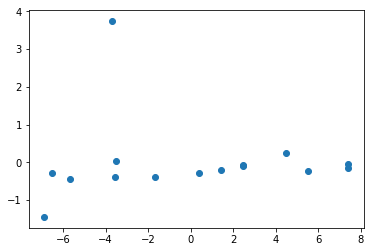

In [71]:
# Step 3

kmeans1 = KMeans(n_clusters = 15)
kmeans1.fit(vectorized_folders_df)
labels1 = kmeans1.predict(vectorized_folders_df)
vectorized_folders_df['label'] = labels1

centers1 = kmeans1.cluster_centers_

pca_model1 = PCA(n_components=2)
centers_pca1 = pca_model1.fit_transform(centers1)
centers_pca1_X = centers_pca1.T[0]
centers_pca1_y = centers_pca1.T[1]

print(centers_pca1_X)
print(centers_pca1_y)

plt.scatter(centers_pca1_X, centers_pca1_y)

In [72]:
vectorized_folders_df

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,label
sent,-0.0170898,0.021729,0.225586,-0.129883,-0.199219,-0.107910,-0.184570,-0.083984,0.004974,0.111328,...,-0.283203,-0.051758,0.112305,0.267578,0.059082,0.144531,-0.091309,-0.069824,-0.021606,5
all documents,0.0449219,0.018005,0.032593,-0.016846,-0.022888,0.009766,0.034180,0.085632,0.114258,-0.102783,...,-0.100586,-0.078613,-0.029541,-0.131592,0.081787,0.098389,-0.126709,-0.048218,0.020508,5
contact,0.046875,-0.239258,-0.003036,-0.224609,-0.124512,0.302734,-0.007172,0.043945,0.025024,-0.106934,...,0.312500,0.198242,0.069824,0.231445,0.083008,0.177734,0.054688,-0.085449,-0.183594,5
deleted,-0.172852,-0.047852,0.316406,0.145508,-0.220703,0.009521,-0.028076,0.216797,0.507812,0.092285,...,0.076660,0.363281,-0.200195,0.287109,-0.263672,0.196289,-0.361328,-0.050537,-0.070801,5
discussion,-0.0390625,0.042236,0.014465,0.115234,0.132812,-0.101074,0.164062,-0.100098,0.123535,0.005585,...,-0.175781,0.326172,0.152344,0.042236,-0.011536,-0.125000,-0.229492,-0.112305,-0.158203,5
misc,-0.116699,-0.078613,-0.135742,0.205078,-0.029175,-0.014526,-0.152344,0.037598,-0.233398,0.087402,...,-0.090820,0.083008,-0.057617,-0.375000,-0.441406,-0.077637,-0.281250,-0.255859,0.160156,1
note,-0.0874023,0.253906,-0.217773,-0.135742,-0.144531,0.084473,0.279297,-0.085449,0.201172,-0.021118,...,-0.010254,0.137695,-0.176758,-0.010986,-0.283203,0.024902,-0.069336,-0.003021,0.023804,5
straw,0.192383,0.100098,-0.071777,-0.205078,-0.148438,-0.156250,0.355469,0.044678,-0.040283,0.156250,...,0.038818,0.026978,0.024658,-0.039551,0.004486,-0.128906,-0.173828,-0.180664,-0.010437,8
2000 conference,-0.0732422,0.059082,0.121094,-0.038330,0.031494,-0.074707,0.067383,-0.041992,0.034424,0.057373,...,-0.059082,0.039062,0.004364,0.083984,-0.097656,-0.096191,-0.038330,-0.096191,0.019653,7
active international,-0.0966797,0.077820,-0.037598,0.071045,-0.048096,-0.042969,-0.048279,-0.232910,0.102417,-0.028900,...,0.047302,0.023499,-0.046631,-0.012207,0.100586,-0.019775,0.217773,0.031555,0.041748,13


In [73]:
# # Remove the word embedding columns from vectorized_folders_df
# vectorized_folders_df = vectorized_folders_df.reset_index().rename(columns = {'index': 'subject'})
# vectorized_folders_df = vectorized_folders_df[['subject', 'label']]

# Remove the word embedding columns from vectorized_folders_df
vectorized_folders_df1 = vectorized_folders_df.reset_index().rename(columns = {'index': 'folder'})
vectorized_folders_df1 = vectorized_folders_df1[['folder', 'label']]
vectorized_folders_df1

,folder,label
0,sent,5
1,all documents,5
2,contact,5
3,deleted,5
4,discussion,5
5,misc,1
6,note,5
7,straw,8
8,2000 conference,7
9,active international,13


Unfortunately, many of these items were not placed in the correct label. After much manual feature engineering (refer to the PDF labeled 'Updated_labels' for more details) to modify the labels, we read in the NEW_vectorized_folders_df instead.

In [74]:
vectorized_folders_df1.head()

,folder,label
0,sent,5
1,all documents,5
2,contact,5
3,deleted,5
4,discussion,5


In [75]:
data2.head()

,date,day,subject,message,cc,bcc,folder,time,reply,message_length,subject_length
1,2001-05-04 13:51:00,fri,re,traveling business meeting takes fun trip esp...,0,0,sent,988984260,1,84,1
2,2000-10-18 03:00:00,wed,re test,test successful way go,0,0,sent,971838000,1,5,2
4,2000-08-31 05:07:00,thu,re hello,lets shoot tuesday 1145,0,0,sent,967698420,1,6,2
5,2000-08-31 04:17:00,thu,re hello,greg either next tuesday thursdayphillip,0,0,sent,967695420,1,5,2
7,2000-07-14 06:59:00,fri,re prc review phone calls,morning 10 1130,0,0,sent,963557940,1,3,6


In [76]:
df = pd.merge(data2, vectorized_folders_df1, on = 'folder')

In [79]:
df.groupby('label').count().sort_values('subject', ascending=False)

,date,day,subject,message,cc,bcc,folder,time,reply,message_length,subject_length
label,,,,,,,,,,,
5,405170,405170,405170,405170,405170,405170,405170,405170,405170,405170,405170
1,51212,51212,51212,51212,51212,51212,51212,51212,51212,51212,51212
7,11405,11405,11405,11405,11405,11405,11405,11405,11405,11405,11405
13,6451,6451,6451,6451,6451,6451,6451,6451,6451,6451,6451
4,6412,6412,6412,6412,6412,6412,6412,6412,6412,6412,6412
14,6149,6149,6149,6149,6149,6149,6149,6149,6149,6149,6149
2,5709,5709,5709,5709,5709,5709,5709,5709,5709,5709,5709
8,2036,2036,2036,2036,2036,2036,2036,2036,2036,2036,2036
9,1932,1932,1932,1932,1932,1932,1932,1932,1932,1932,1932


In [80]:
data_filtered = df[(df['label'] != 1) & 
                     (df['label'] != 5)]

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, make_scorer

In [37]:
# dfDummies = pd.get_dummies(df['day'], prefix = 'day= ')
# df = pd.concat([df, dfDummies], axis=1)
# df = df.drop(labels='day', axis=1)

In [82]:
dfDummies1 = pd.get_dummies(data_filtered['day'], prefix = 'day= ')
data_filtered = pd.concat([data_filtered, dfDummies1], axis=1)
data_filtered = data_filtered.drop(labels='day', axis=1)

In [83]:
# df = df.drop(['date', 'subject', 'message', 'folder'], axis = 1)
# df['log message'] = df.message_length.apply(np.log)
# df['log time'] = df.time.apply(np.log)
# df.head()

In [84]:
data_filtered = data_filtered.drop(['date', 'subject', 'message', 'folder'], axis = 1)
data_filtered['log message'] = data_filtered.message_length.apply(np.log)
data_filtered['log time'] = data_filtered.time.apply(np.log)
data_filtered.head()

,cc,bcc,time,reply,message_length,subject_length,label,day= _fri,day= _mon,day= _sat,day= _sun,day= _thu,day= _tue,day= _wed,log message,log time
428833,0,0,953053620,0,25,4,8,0,0,0,0,0,1,0,3.218876,20.675182
428834,1,0,950773020,1,104,7,8,0,0,0,0,1,0,0,4.644391,20.672786
428835,1,0,950770860,0,106,6,8,0,0,0,0,1,0,0,4.663439,20.672784
428836,0,0,950147160,1,31,2,8,0,0,0,0,1,0,0,3.433987,20.672127
428837,0,0,947262540,1,153,3,8,1,0,0,0,0,0,0,5.030438,20.669087


In [86]:
data_filtered.shape

(41825, 16)

In [87]:
# X, y = df.drop('label', axis = 1), df.values[:, 6]
X1, y1 = data_filtered.drop('label', axis = 1), data_filtered.values[:, 6]

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.3, random_state = 100)

In [89]:
clf = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=630, min_samples_leaf=3000)
clf.fit(X_train, y_train)
print("Accuracy Score of Decision Tree on test set",clf.score(X_test, y_test)*100,'%')

Accuracy Score of Decision Tree on test set 29.311444054829455 %


In [90]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
# Y_train_pred = rf.predict(X_train)
# Y_test_pred_rf = rf.predict(X_test)
print("Accuracy Score of Random Forests on test set",rf.score(X_test, y_test)*100,'%')
# accuracy_score(y_test, Y_test_pred)

Accuracy Score of Random Forests on test set 35.04144086707045 %


In [93]:
kfold = KFold(n_splits=30, random_state=0)
bag = BaggingClassifier(base_estimator=clf, n_estimators=100,
                        random_state=42, max_samples=0.5, max_features=0.5)
bag.fit(X_train, y_train)
# results = cross_val_score(bag, X1, y1, cv=kfold)
# print('Bagging: ', results.mean())

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=0.5,
         max_samples=0.5, n_estimators=100, n_jobs=None, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [94]:
print("Accuracy Score of Bagging on train set", bag.score(X_train, y_train)*100,'%')
print("Accuracy Score of Bagging on test set",bag.score(X_test, y_test)*100,'%')

Accuracy Score of Bagging on train set 93.13112682310346 %
Accuracy Score of Bagging on test set 37.097545425565826 %


In [95]:
voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('clf', clf), ('bag', bag)],
    voting='hard')

voting_clf.fit(X_train, y_train)

print("Accuracy Score of Voting Classifier on test set", voting_clf.score(X_train, y_train)*100,'%')
print("Accuracy Score of Voting Classifier on test set", voting_clf.score(X_test, y_test)*100,'%')

Accuracy Score of Voting Classifier on test set 94.586193940636 %
Accuracy Score of Voting Classifier on test set 35.83838061842525 %


In [96]:
def rmsle(pred_val, act_val):
    pred_val = np.array(pred_val)
    act_val = np.array(act_val)
    
    log_predict, log_actual = np.log(pred_val + 1), np.log(act_val + 1)
    
    diff = np.square(log_predict - log_actual)
    mean_diff = diff.mean()
    return np.sqrt(mean_diff)

rmsle_scorer = make_scorer(rmsle)
# the lesser the better
%time score = cross_val_score(rf, X_train, y_train, cv=kfold, scoring=rmsle_scorer)
score = score.mean()
print("Random Forest: ", "Score= {0:.5f}".format(score))

%time score = cross_val_score(clf, X_train, y_train, cv=kfold, scoring=rmsle_scorer)
score = score.mean()
print("Decision Tree: ", "Score= {0:.5f}".format(score))

%time score = cross_val_score(bag, X_train, y_train, cv=kfold, scoring=rmsle_scorer)
score = score.mean()
print("Bagging with Decision Tree: ", "Score= {0:.5f}".format(score))

%time score = cross_val_score(voting_clf, X_train, y_train, cv=kfold, scoring=rmsle_scorer)
score = score.mean()
print("Voting Classifier: ", "Score= {0:.5f}".format(score))

CPU times: user 2min 7s, sys: 8.89 s, total: 2min 16s
Wall time: 2min 21s
Random Forest:  Score= 0.65493
CPU times: user 7.37 s, sys: 181 ms, total: 7.55 s
Wall time: 8.48 s
Decision Tree:  Score= 0.68427
CPU times: user 2min 13s, sys: 3.97 s, total: 2min 17s
Wall time: 2min 28s
Bagging with Decision Tree:  Score= 0.63137
CPU times: user 4min 22s, sys: 11.6 s, total: 4min 33s
Wall time: 4min 40s
Voting Classifier:  Score= 0.66253


Feature ranking:
           feature  importance
2             time    0.203365
14        log time    0.199665
13     log message    0.157330
4   message_length    0.154489
5   subject_length    0.125544
3            reply    0.026053
7        day= _mon    0.022468
12       day= _wed    0.021597
10       day= _thu    0.021091
11       day= _tue    0.021062
6        day= _fri    0.020167
0               cc    0.017863
9        day= _sun    0.005466
8        day= _sat    0.003839
1              bcc    0.000000


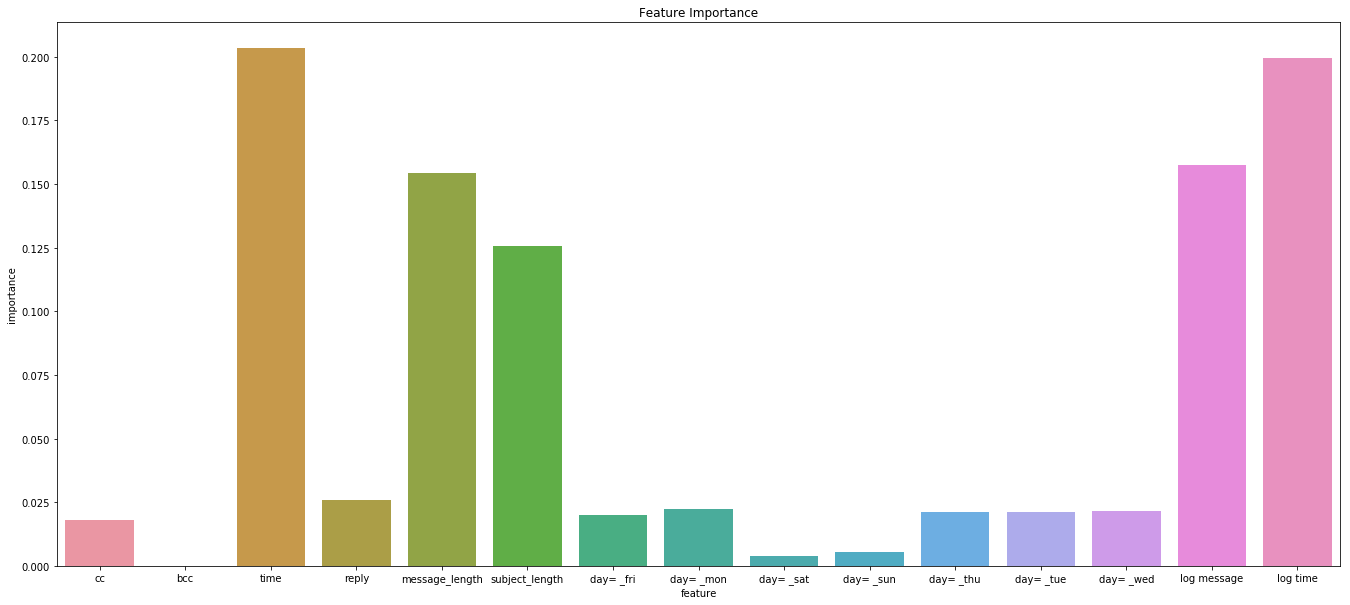

In [97]:
# Feature Importance Exploration for DT
importances = clf.feature_importances_
imp = pd.DataFrame()
imp['feature'], imp['importance'] = X_train.columns, importances
print("Feature ranking:")
print(imp.sort_values(by='importance', ascending=False))
plt.figure(figsize=(23, 10))
sns.barplot(x='feature', y='importance', data=imp)
plt.title('Feature Importance')
plt.show()

Feature ranking:
           feature  importance
2             time    0.225744
14        log time    0.221160
4   message_length    0.172007
13     log message    0.171689
5   subject_length    0.109168
3            reply    0.017554
0               cc    0.015098
10       day= _thu    0.012497
11       day= _tue    0.012431
12       day= _wed    0.012347
7        day= _mon    0.012275
6        day= _fri    0.011509
9        day= _sun    0.003872
8        day= _sat    0.002528
1              bcc    0.000120


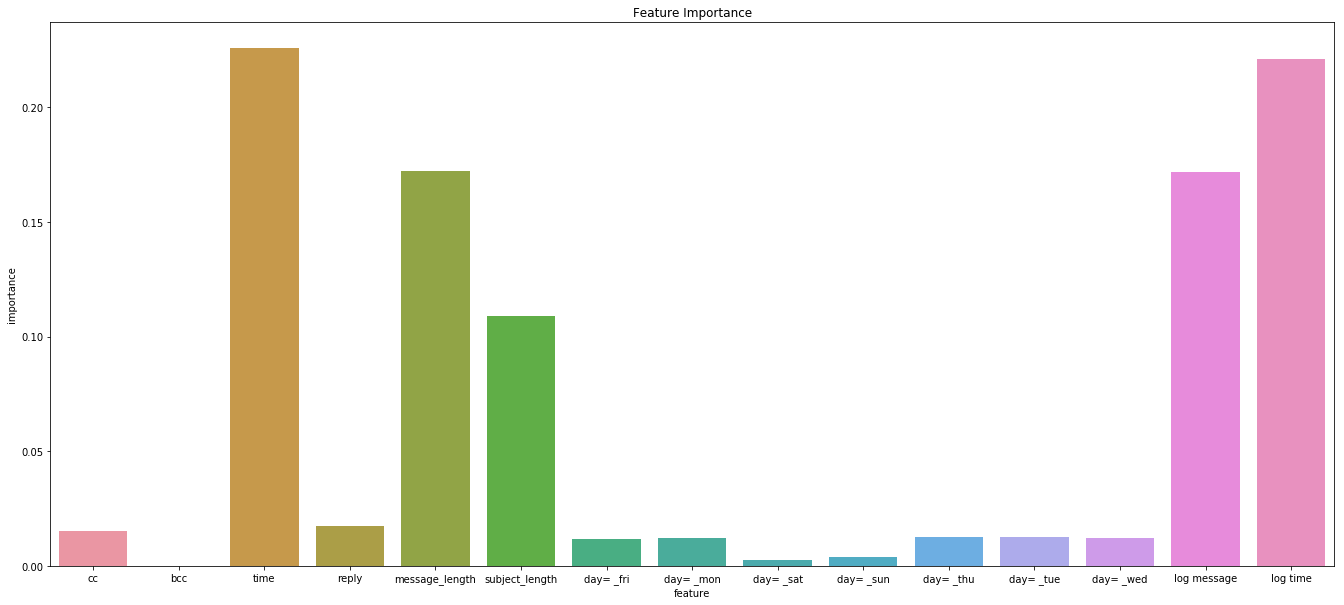

In [98]:
# Feature Importance Exploration for RF
importances = rf.feature_importances_
imp = pd.DataFrame()
imp['feature'], imp['importance'] = X_train.columns, importances
print("Feature ranking:")
print(imp.sort_values(by='importance', ascending=False))
plt.figure(figsize=(23, 10))
sns.barplot(x='feature', y='importance', data=imp)
plt.title('Feature Importance')
plt.show()